<a href="https://colab.research.google.com/github/kreitika/Visual-Illusion-NeuroAI/blob/main/Visual_Illusion_NeuroAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing all basic libraries needed for images, arrays, and plotting.
# These are the usual ones used in most computer vision work.
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow


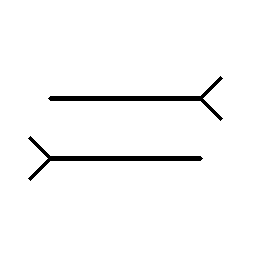

In [ ]:
# I am creating the classic Müller-Lyer illusion.
# Even though these two lines are actually the SAME length,
# humans see one as longer because of the arrowheads.

def muller_lyer(size=256):
    img = np.ones((size, size, 3), dtype=np.uint8) * 255  # plain white background

    center = size // 2

    # two horizontal lines
    cv2.line(img, (50, center - 30), (200, center - 30), (0, 0, 0), 3)
    cv2.line(img, (50, center + 30), (200, center + 30), (0, 0, 0), 3)

    # arrowheads to create the illusion effect
    cv2.line(img, (200, center - 30), (220, center - 50), (0,0,0), 3)
    cv2.line(img, (200, center - 30), (220, center - 10), (0,0,0), 3)

    cv2.line(img, (50, center + 30), (30, center + 10), (0,0,0), 3)
    cv2.line(img, (50, center + 30), (30, center + 50), (0,0,0), 3)

    return img

illusion_img = muller_lyer()
cv2_imshow(illusion_img)


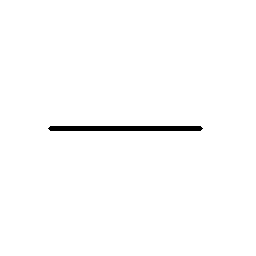

In [ ]:
# Now I create a simple control image with no illusion.
# This helps me compare how the model reacts with vs without the illusion.

def control_line(size=256):
    img = np.ones((size, size, 3), dtype=np.uint8) * 255
    center = size // 2
    cv2.line(img, (50, center), (200, center), (0,0,0), 3)
    return img

control_img = control_line()
cv2_imshow(control_img)


In [ ]:
# I'm using MobileNetV2 because it's lightweight and loads quickly in Colab.
# This model is already trained on ImageNet, so it has "learned" visual features.

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model = MobileNetV2(weights='imagenet')
model.summary()  # just to check the architecture


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# CNNs like MobileNetV2 want input images of size 224x224 and normalized.
# This small function prepares any image we pass into it.

def prepare(img):
    img_resized = cv2.resize(img, (224, 224))
    img_batch = np.expand_dims(img_resized, axis=0)  # making it batch size 1
    img_prep = preprocess_input(img_batch)
    return img_prep


In [ ]:
# I want to check how the CNN "sees" the illusion internally.
# For this, I'm taking an early layer that behaves somewhat like human V1/V2.

from tensorflow.keras import Model

layer_name = 'block_1_expand_relu'  # early visual-processing layer
vision_model = Model(inputs=model.input,
                     outputs=model.get_layer(layer_name).output)

# Run the illusion through this early-vision layer
illusion_act = vision_model.predict(prepare(illusion_img))
illusion_act.shape


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


(1, 112, 112, 96)

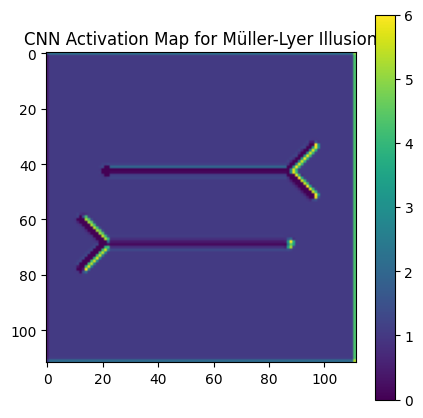

In [ ]:
# I'm visualizing one activation channel to see what the CNN focuses on.
# It's like looking at "which neurons lit up" when the model saw the illusion.

act_map = illusion_act[0, :, :, 0]

plt.figure(figsize=(5, 5))
plt.imshow(act_map, cmap='viridis')
plt.title("CNN Activation Map for Müller-Lyer Illusion")
plt.colorbar()
plt.show()


In [ ]:
# Now I compare the activation maps of the illusion image
# and the normal control line (non-illusion).
# If the difference is large, it means the model's perception changes
# even though the lines are actually identical lengths.

control_act = vision_model.predict(prepare(control_img))

diff_value = np.abs(illusion_act - control_act).mean()
diff_value


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


np.float32(0.10330061)

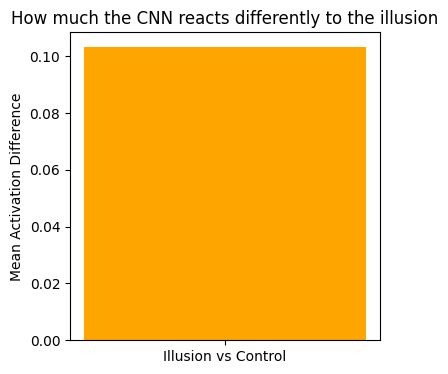

In [ ]:
# Just a simple bar plot so I can put it in my report later.
# This shows how different the CNN's internal state is for illusion vs control.

plt.figure(figsize=(4,4))
plt.bar(['Illusion vs Control'], [diff_value], color='orange')
plt.ylabel("Mean Activation Difference")
plt.title("How much the CNN reacts differently to the illusion")
plt.show()


In [ ]:
# Writing down a small interpretation as a print output.
# This text I can reuse later in the PDF report.

if diff_value > 1.0:
    print("The CNN shows a strong difference in activations. It seems sensitive to the illusion.")
else:
    print("The CNN shows only a small difference. It may not be strongly influenced by the illusion.")


The CNN shows only a small difference. It may not be strongly influenced by the illusion.
